# Load GDrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Pre-requisites

In [126]:
import os
import random
import requests
from glob2 import glob

import torch

import cv2
from IPython.display import  display, Image
# import PIL

In [3]:
!git clone --quiet --depth=1 https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

/content/yolov5
     |████████████████████████████████| 645kB 4.2MB/s 


# System Info

In [ ]:
# Check CUDA info
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f'Current device : {torch.cuda.current_device()}')
    for i in range(torch.cuda.device_count()):
        print(f"{torch.cuda.get_device_name(i)}  @  {torch.cuda.device(i)}")
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    print("CPU")

Current device : 0
Tesla T4  @  <torch.cuda.device object at 0x7f7670fe8a50>
Allocated: 0.0 GB
Cached:    0.0 GB


# Test Prediction

## From Repo

In [ ]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/

detect: weights=['yolov5s.pt'], source=data/images/, imgsz=640, conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 3c3f8fb torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

100% 14.1M/14.1M [00:00<00:00, 64.7MB/s]

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7266973 parameters, 0 gradients
image 1/2 /content/yolov5/data/image

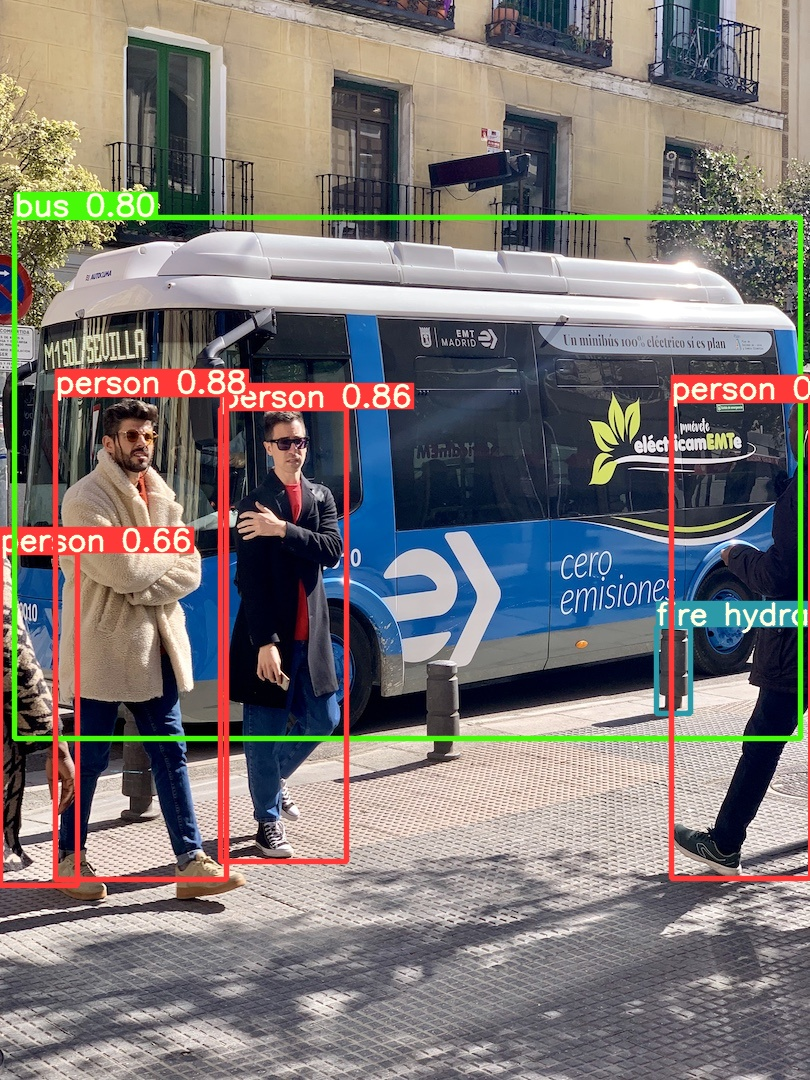

In [ ]:
Image(filename='runs/detect/exp/bus.jpg', width=600)

## From Torch Hub

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-7-8 torch 1.9.0+cu102 CPU




requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Fusing layers... 


Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


image 1/1: 720x1280 2 persons, 2 ties
Speed: 726.2ms pre-process, 285.7ms inference, 1.8ms NMS per image at shape (1, 3, 384, 640)
         xmin        ymin         xmax        ymax  confidence  class    name
0  749.628418   43.006439  1148.310059  708.739380    0.876501      0  person
1  433.496338  433.949493   517.907959  715.133057    0.658129     27     tie
2  113.315674  196.359955  1093.051270  710.308350    0.596341      0  person
3  986.139587  304.344147  1027.974243  420.158539    0.285011     27     tie
Saved zidane.jpg to runs/hub/exps


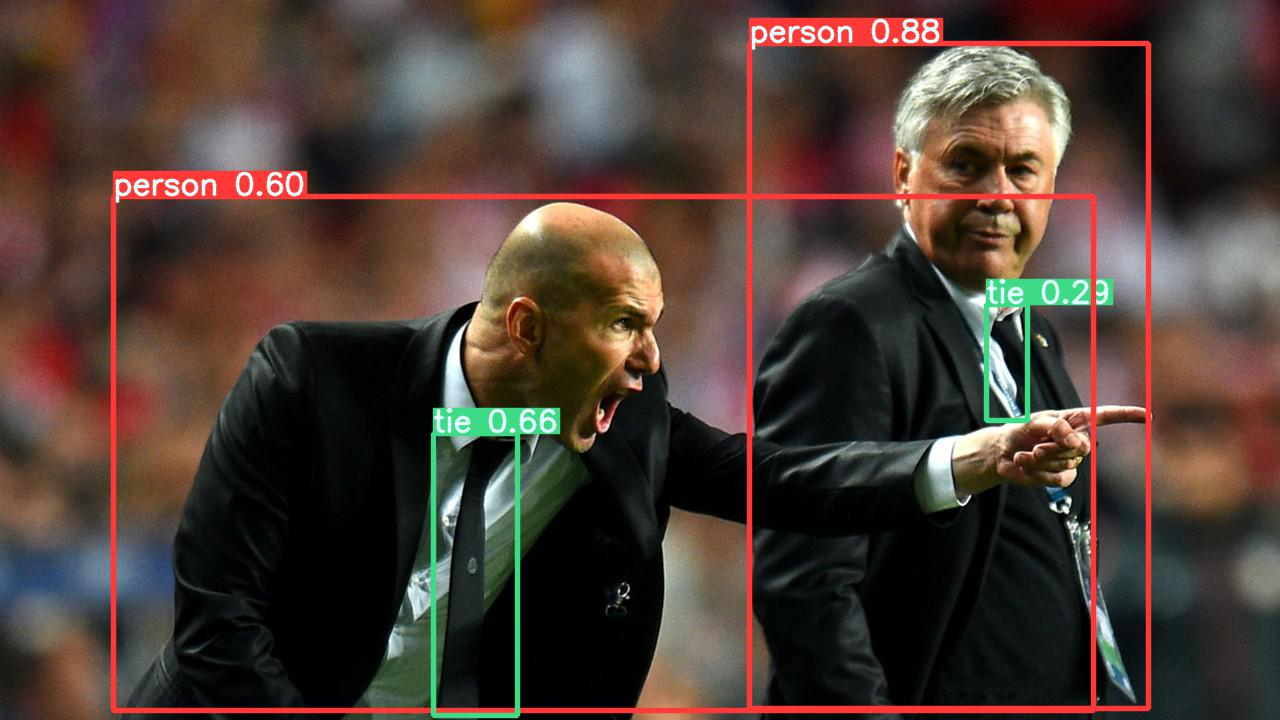

In [129]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

### Model Configs ###
# model.conf = 0.25  # confidence threshold (0-1)
# model.iou = 0.45  # NMS IoU threshold (0-1)
# model.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs

img = 'https://ultralytics.com/images/zidane.jpg'
results = model(img)
results.print() 
print(results.pandas().xyxy[0])
results.save('runs/hub/exps/')
Image('runs/hub/exps/' + 'zidane.jpg', width=600)

# FILENAME = 'zidane.jpg'
# img_raw = requests.get('https://ultralytics.com/images/' + FILENAME).content
# with open(FILENAME, 'wb') as f:
#     f.write(img_raw)
# imgs = [PIL.Image.open(FILENAME)]

# model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
# results = model(imgs, size=640)
# results.print() 
# print(results.pandas().xyxy[0])
# results.save('runs/hub/exp/')
# Image('runs/hub/exp/' + FILENAME)

# Custom Object Detection

## Training

In [43]:
%%shell
wget -q https://raw.githubusercontent.com/theAIGuysCode/yolov4-custom-functions/master/core/functions.py
mkdir data/food
unzip -q -o /content/gdrive/MyDrive/Dataset/Food/train.zip -d ./data/food
unzip -q -o /content/gdrive/MyDrive/Dataset/Food/test.zip -d ./data/food
unzip -q -o /content/gdrive/MyDrive/Dataset/Food/validation.zip -d ./data/food

In [ ]:
%pip install -q wandb
import wandb
wandb.login()
# While training, check for log at https://wandb.ai/home?utm_campaign=repo_yolo_notebook

In [ ]:
%%writefile data/food.yaml

# train and val datasets (image directory or *.txt file with image paths)
# path: data
train: ./data/food/train
val: ./data/food/validation
test: ./data/food/test 

# number of classes
nc: 1

# class names
names: ['Food']

Writing data/food.yaml


In [ ]:
# weight file is automatically fetched from : https://github.com/ultralytics/yolov5/releases
# uncomment `anchor` in hyp file if using --evolve\
# use --exist-ok to replace last run result
!python train.py --data data/food.yaml --cfg models/yolov5l.yaml --weights yolov5l6.pt --hyp data/hyps/hyp.finetune.yaml \
    --img-size 640 640 --batch-size 24 --epochs 200 --workers 8 --save_period -1  \
    --single-cls --cache-images \
    --project /content/gdrive/MyDrive/Backup/YOLOv5/Food --name exp 

train: weights=yolov5l6.pt, cfg=models/yolov5l.yaml, data=data/food.yaml, hyp=data/hyps/hyp.finetune.yaml, epochs=200, batch_size=24, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=None, bucket=, cache_images=True, image_weights=False, device=, multi_scale=False, single_cls=True, adam=False, sync_bn=False, workers=8, project=/content/gdrive/MyDrive/Backup/YOLOv5/Food, entity=None, name=exp, exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 33202b7 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

hyperparameters: lr0=0.0032, lrf=0.12, momentum=0.843, weight_decay=0.00036, warmup_epochs=2.0, warmup_momentum=0.5, warmup_bias_lr=0.05, box=0.0296, cls=0.243, cls_pw=0.631, obj=0.301, obj_pw=0.911, iou_t=0.2, anchor_t=2.91, fl_gamma=0.0, hsv_h=0.0138, hsv_s=0.6

## Train Log

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs/train

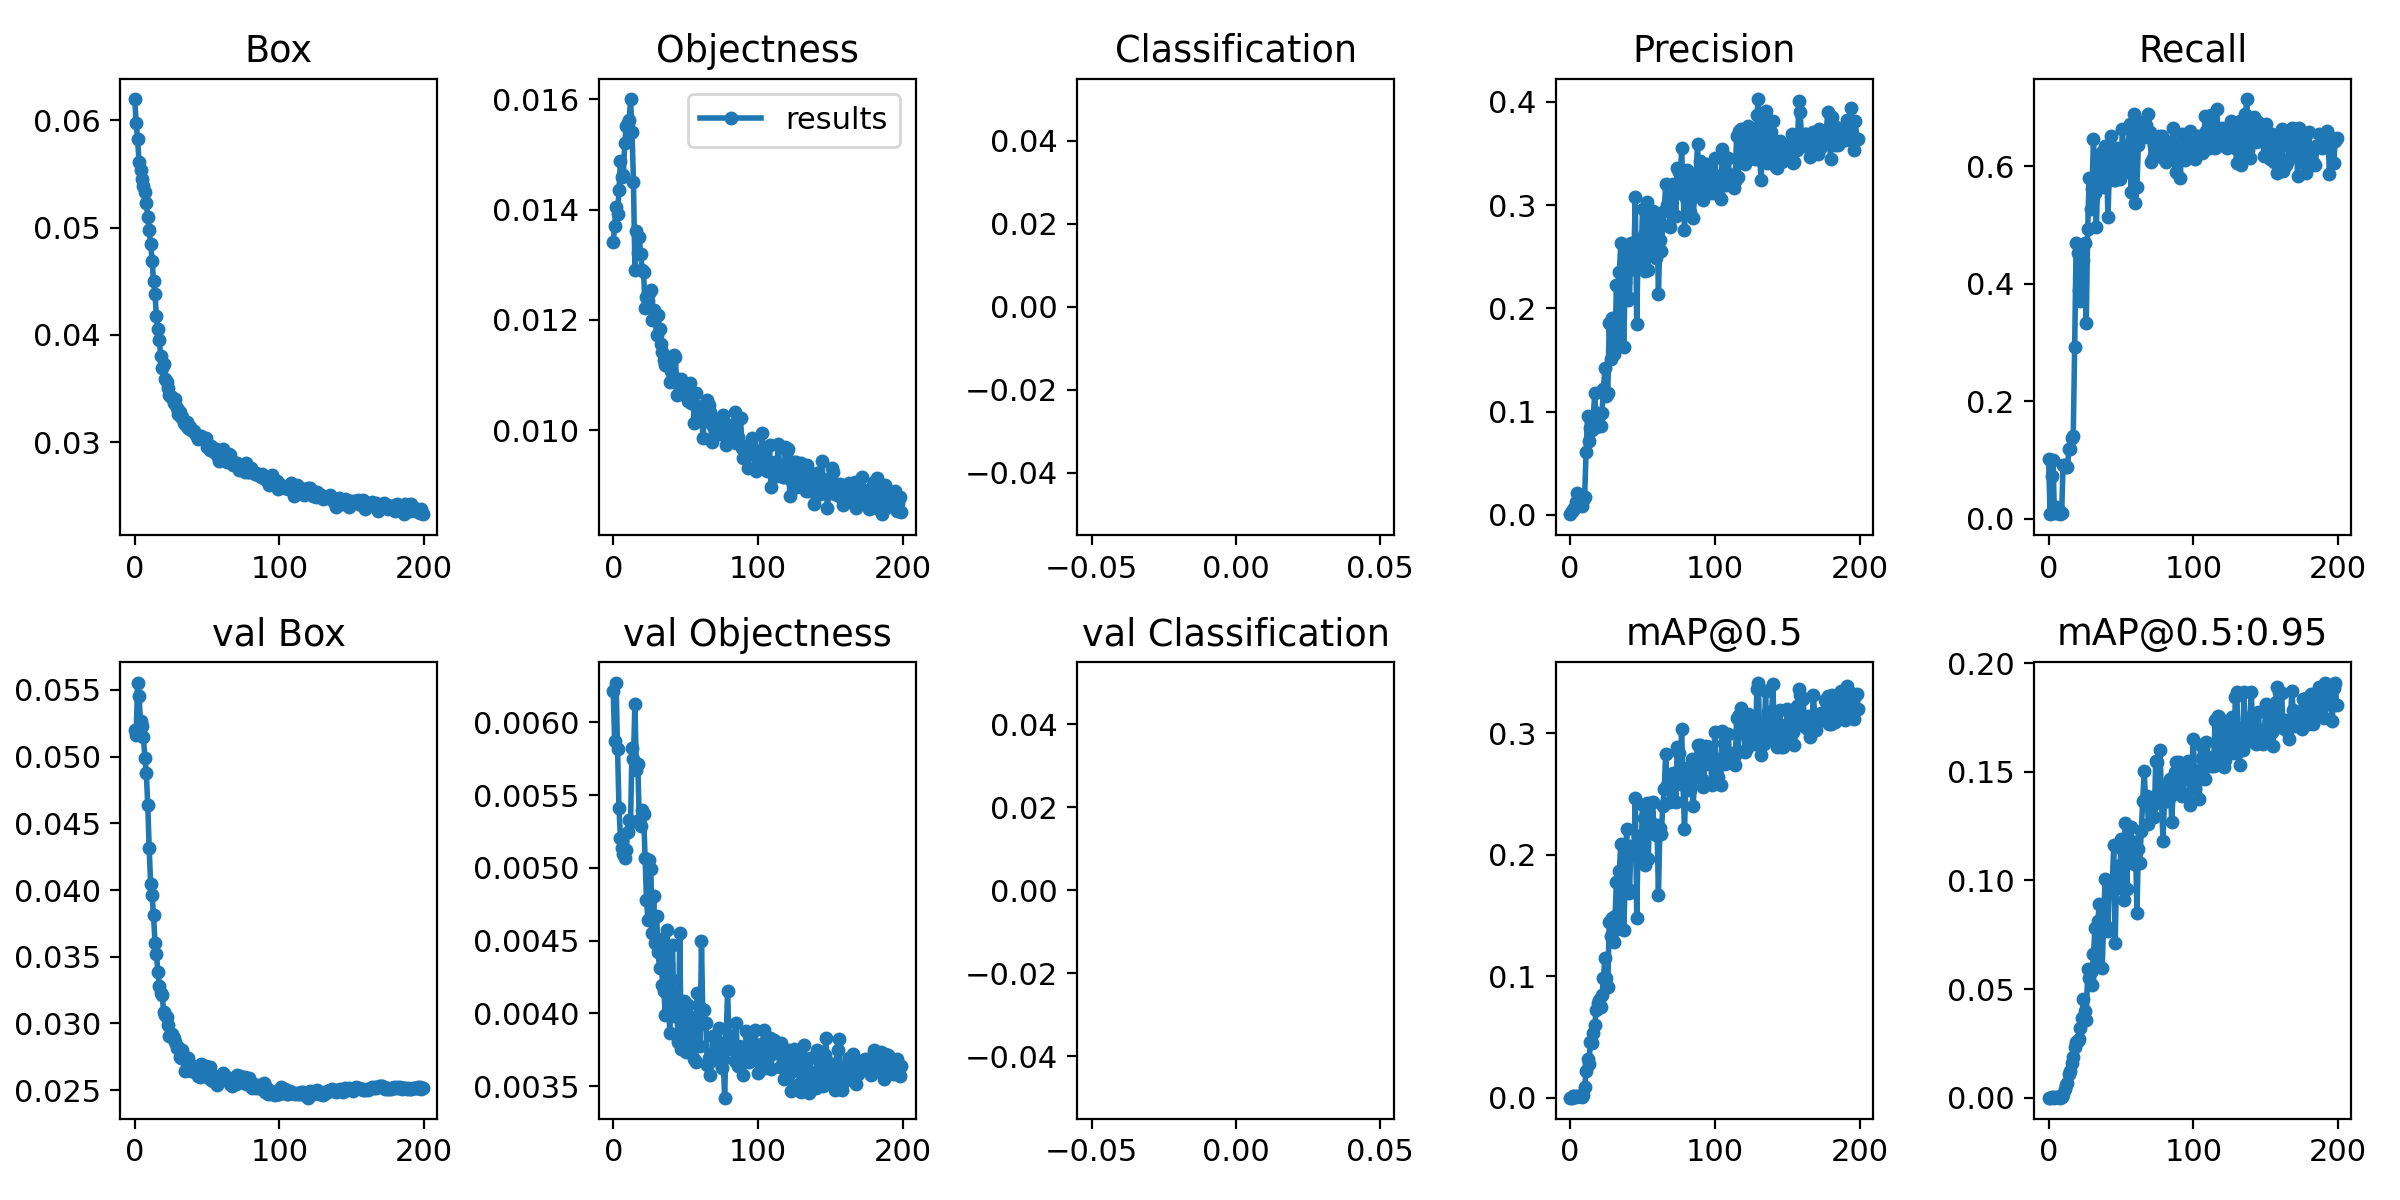

In [ ]:
from utils.plots import plot_results 
plot_results(save_dir='/content/gdrive/MyDrive/Backup/YOLOv5/Food/exp')  # plot all results*.txt files
Image(filename='/content/gdrive/MyDrive/Backup/YOLOv5/Food/exp/results.png', width=800)

TRAINING DATA (GROUND TRUTH):


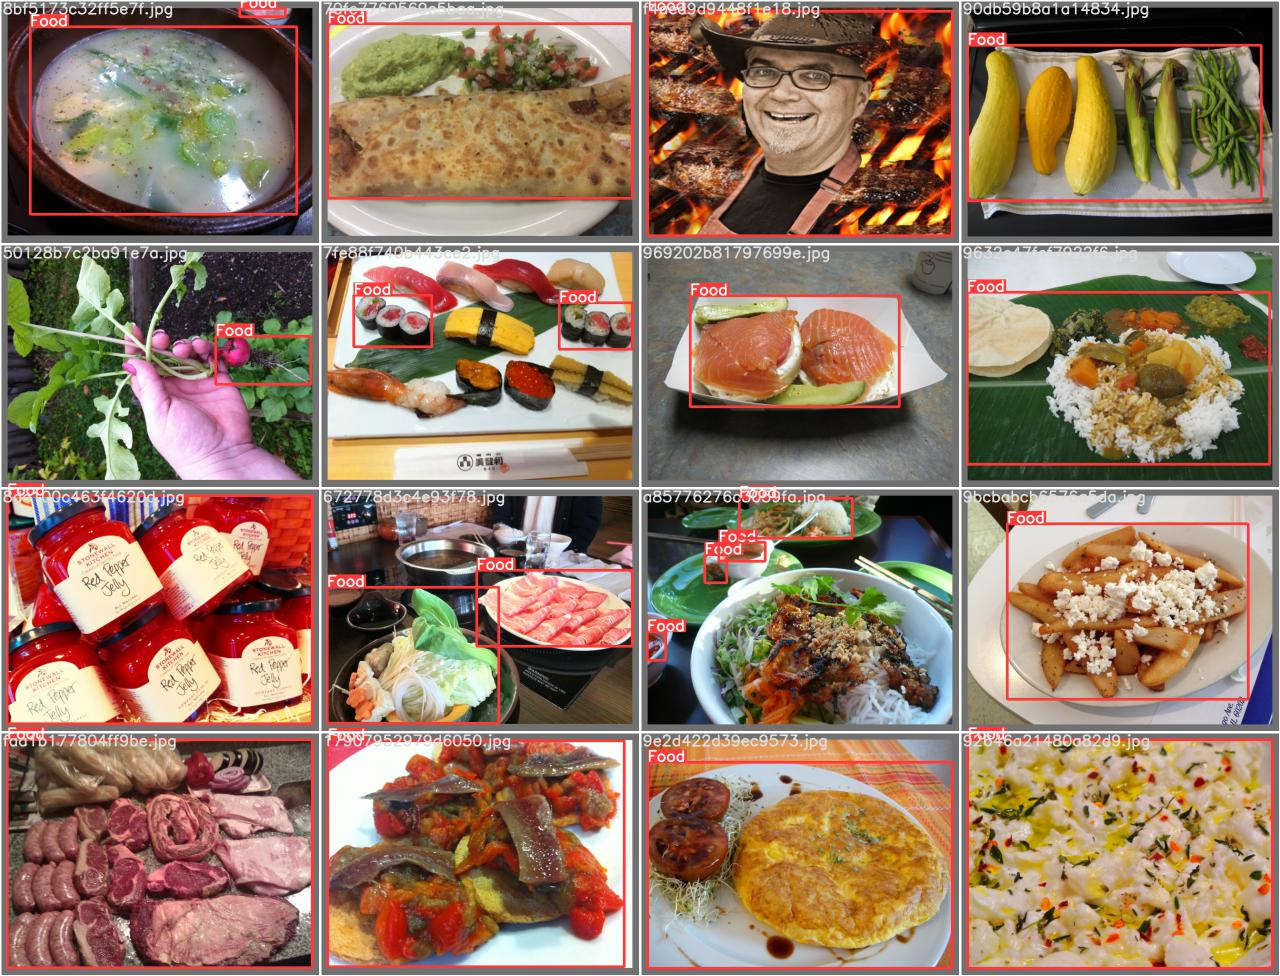

In [ ]:
print("TRAINING DATA (GROUND TRUTH):")
Image(filename='/content/gdrive/MyDrive/Backup/YOLOv5/Food/exp/test_batch_labels.jpg', width=900)

PREDICTION:


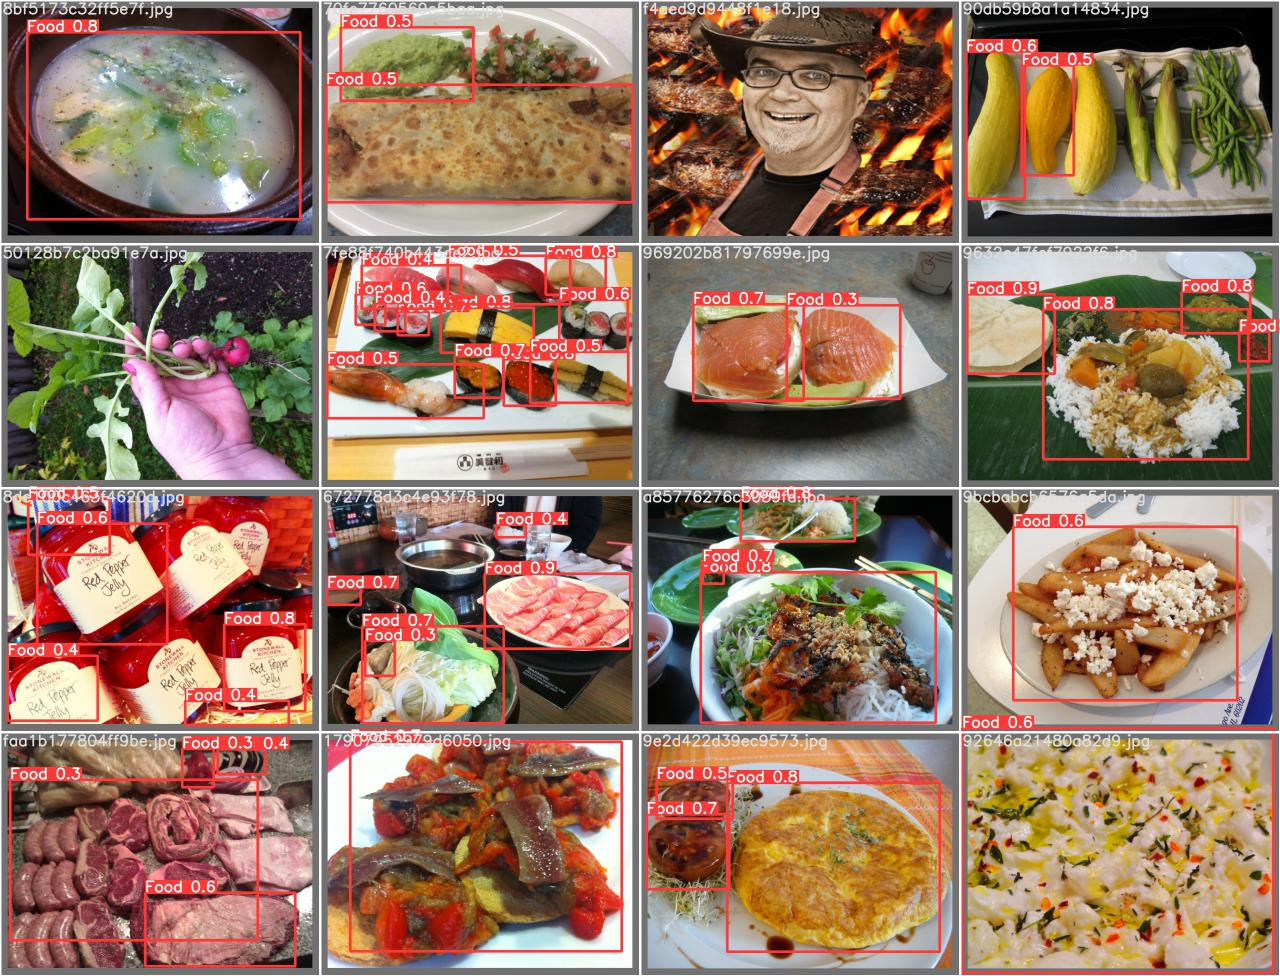

In [ ]:
print("PREDICTION:")
Image(filename='/content/gdrive/MyDrive/Backup/YOLOv5/Food/exp/test_batch_pred.jpg', width=900)

## Prediciton

In [44]:
# img = os.path.basename(random.choice(glob('data/food/test/*.jpg')))
img = '5bc21601ccdc7544.jpg'
Image('./data/food/test/' + img)

!rm -rf runs/detect/img/
!mkdir -p runs/detect/img
!cp /content/yolov5/data/food/test/$img runs/detect/img/

### Repo

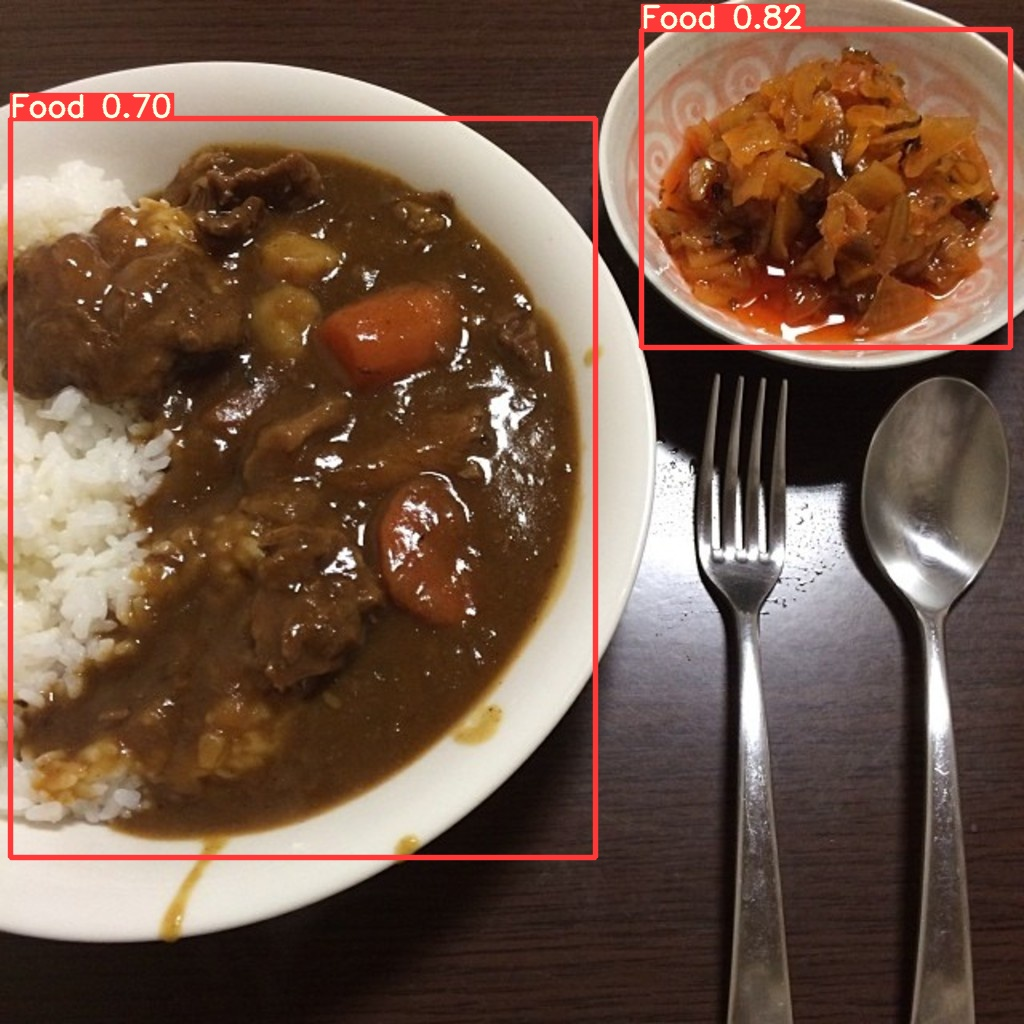

In [115]:
!python detect.py --weights /content/gdrive/MyDrive/Backup/YOLOv5/Food/exp/weights/best.pt --img 640 --conf 0.25 --source runs/detect/img/ --name exp --exist-ok
Image('runs/detect/exp/' + img, width=600)

### PyTorch Hub

In [17]:
#     --data data/food.yaml --cfg models/yolov5l.yaml --weights yolov5l6.pt --hyp data/hyps/hyp.finetune.yaml \
#     --img-size 640 640 --batch-size 24 --epochs 200 --workers 8 --save_period -1  \
#     --single-cls --cache-images \
#     --project /content/gdrive/MyDrive/Backup/YOLOv5/Food --name exp 

In [29]:
pt_weights = 'yolov5l.pt'
!wget -q -N https://github.com/ultralytics/yolov5/releases/download/v5.0/$pt_weights
state_dict = torch.load(pt_weights)['model'].state_dict()
state_dict = {f'model.{k}': v for k, v in state_dict.items()}
print(len(state_dict.keys()))
state_dict.keys()

650


dict_keys(['model.model.0.conv.conv.weight', 'model.model.0.conv.bn.weight', 'model.model.0.conv.bn.bias', 'model.model.0.conv.bn.running_mean', 'model.model.0.conv.bn.running_var', 'model.model.0.conv.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.cv2.bn.num_batches_tracked', 'model.model.2.cv3.conv.weight', 'model.model.2.cv3.bn.weight', 'model.model.2.cv3.bn.bias', 'model.model.2.cv3.bn.running_mean', 'model.model.2.cv3.bn.running_var', '

In [28]:
pt_weights = 'yolov5l6.pt'
!wget -q -N https://github.com/ultralytics/yolov5/releases/download/v5.0/$pt_weights
state_dict = torch.load(pt_weights)['model'].state_dict()
state_dict = {f'model.{k}': v for k, v in state_dict.items()}
print(len(state_dict.keys()))
state_dict.keys()

832


dict_keys(['model.model.0.conv.conv.weight', 'model.model.0.conv.bn.weight', 'model.model.0.conv.bn.bias', 'model.model.0.conv.bn.running_mean', 'model.model.0.conv.bn.running_var', 'model.model.0.conv.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.cv2.bn.num_batches_tracked', 'model.model.2.cv3.conv.weight', 'model.model.2.cv3.bn.weight', 'model.model.2.cv3.bn.bias', 'model.model.2.cv3.bn.running_mean', 'model.model.2.cv3.bn.running_var', '

In [37]:
state_dict = torch.load('/content/gdrive/MyDrive/Backup/YOLOv5/Food/exp/weights/best.pt')['model'].state_dict()
state_dict = {f'model.{k}': v for k, v in state_dict.items()}
print(len(state_dict.keys()))
state_dict.keys()

650


dict_keys(['model.model.0.conv.conv.weight', 'model.model.0.conv.bn.weight', 'model.model.0.conv.bn.bias', 'model.model.0.conv.bn.running_mean', 'model.model.0.conv.bn.running_var', 'model.model.0.conv.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.cv2.bn.num_batches_tracked', 'model.model.2.cv3.conv.weight', 'model.model.2.cv3.bn.weight', 'model.model.2.cv3.bn.bias', 'model.model.2.cv3.bn.running_mean', 'model.model.2.cv3.bn.running_var', '

In [35]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5l', classes=1)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-7-8 torch 1.9.0+cu102 CPU

Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.Focus                     [3, 64, 3]                    
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  3                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  4                -1  1   1611264  models.common.C3                        [256, 256, 9]                 
  5                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              



requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



  6                -1  1   6433792  models.common.C3                        [512, 512, 9]                 
  7                -1  1   4720640  models.common.Conv                      [512, 1024, 3, 2]             
  8                -1  1   2624512  models.common.SPP                       [1024, 1024, [5, 9, 13]]      
  9                -1  1   9971712  models.common.C3                        [1024, 1024, 3, False]        
 10                -1  1    525312  models.common.Conv                      [1024, 512, 1, 1]             
 11                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 12           [-1, 6]  1         0  models.common.Concat                    [1]                           
 13                -1  1   2757632  models.common.C3                        [1024, 512, 3, False]         
 14                -1  1    131584  models.common.Conv                      [512, 256, 1, 1]              
 15                -1  1         0  t

In [36]:
print(len(model.state_dict().keys()))
model.state_dict().keys()

650


odict_keys(['model.model.0.conv.conv.weight', 'model.model.0.conv.bn.weight', 'model.model.0.conv.bn.bias', 'model.model.0.conv.bn.running_mean', 'model.model.0.conv.bn.running_var', 'model.model.0.conv.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.cv2.bn.num_batches_tracked', 'model.model.2.cv3.conv.weight', 'model.model.2.cv3.bn.weight', 'model.model.2.cv3.bn.bias', 'model.model.2.cv3.bn.running_mean', 'model.model.2.cv3.bn.running_var', 

In [38]:
model.load_state_dict(state_dict)

<All keys matched successfully>

image 1/1: 1024x1024 2 0s
Speed: 48.5ms pre-process, 2681.7ms inference, 1.8ms NMS per image at shape (1, 3, 640, 640)
         xmin        ymin         xmax        ymax  confidence  class name
0  640.873352   29.173609  1010.409851  347.120911    0.816077      0    0
1   10.861914  118.138939   594.748413  857.293152    0.707882      0    0
Saved 5bc21601ccdc7544.jpg to runs/hub/exps


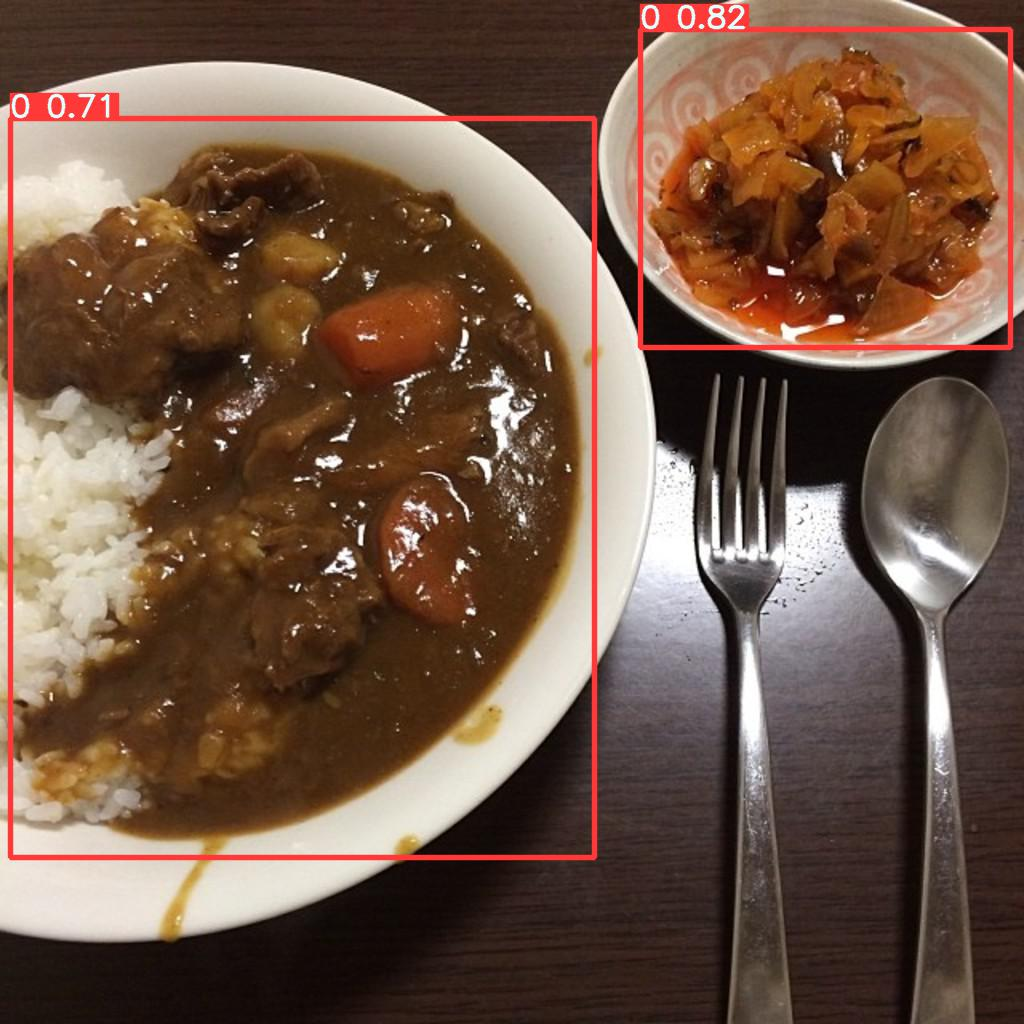

In [117]:
results = model('runs/detect/img/' + img)
results.print() 
print(results.pandas().xyxy[0])
results.save('runs/hub/exps/')
Image('runs/hub/exps/' + img, width=600)

In [110]:
def crop_objects(img_raw, results, path):
    df = results.pandas().xyxy[0][['xmin', 'ymin', 'xmax', 'ymax']]
    xmin, ymin, xmax, ymax = df.T.values
    num_objects = len(df)

    img_raw_name = img_raw.split('/')[-1].split('.')[0]
    img = cv2.imread(img_raw)

    cropped_path = []
    for i in range(num_objects):
        cropped_img = img[int(ymin[i]):int(ymax[i]), int(xmin[i]):int(xmax[i])]
        img_name = img_raw_name + '_' + str(i) + '.png'
        img_path = os.path.join(path, img_name )
        cv2.imwrite(img_path, cropped_img)
        cropped_path.append(img_path)

    return cropped_path

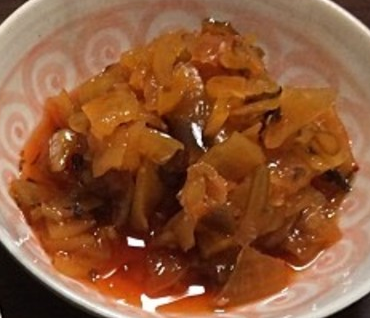

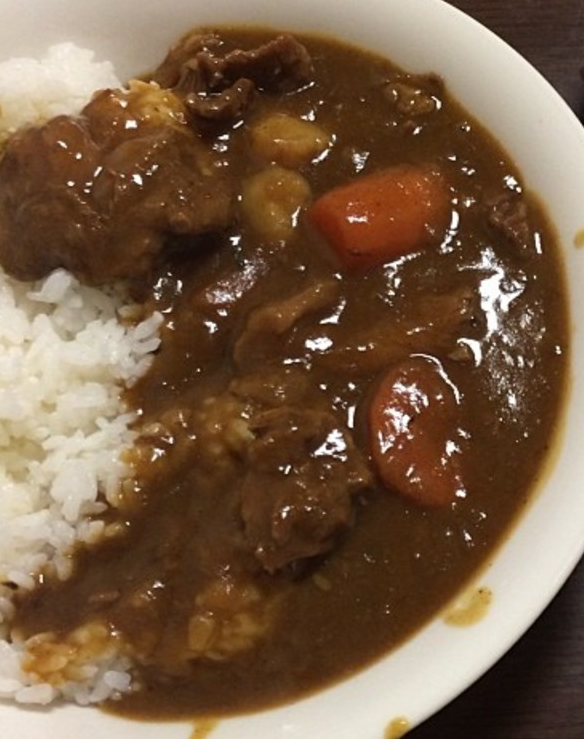

In [125]:
outputs = crop_objects('runs/detect/img/' + img, results, 'runs/hub/exps/cropped')
for i in outputs:
    display(Image(i, width=400))

# Avoid Colab Disconnection

In [5]:
from IPython.display import clear_output
import time
i = 0
while True:    
    time.sleep(60)   
    clear_output(wait=True) 
    i += 1
    print(i)

13


KeyboardInterrupt: ignored

paste this in inspect console to avoid idle kick-out by simulating clicks

```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```

# Snippets

In [ ]:
# Grid Search

# for b, m in zip([64, 48, 32, 16], ['yolov5s', 'yolov5m', 'yolov5l', 'yolov5x']):  # zip(batch_size, model)
#   !python train.py --batch {b} --weights {m}.pt --data coco.yaml --epochs 50 --cache --img-size 512 --nosave --hyp hyp.finetune.yaml --project runs/train --name {m}

# for x in 'yolov5s', 'yolov5m', 'yolov5l', 'yolov5x':
#   !python test.py --weights {x}.pt --data coco.yaml --img 640 --conf 0.25 --iou 0.45  # speed
#   !python test.py --weights {x}.pt --data coco.yaml --img 640 --conf 0.001 --iou 0.65  # mAP



# # Unit tests

# %%shell
# export PYTHONPATH="$PWD"  # to run *.py. files in subdirectories

# rm -rf runs  # remove runs/
# for m in yolov5s; do  # models
#   python train.py --weights $m.pt --epochs 3 --img 320 --device 0  # train pretrained
#   python train.py --weights '' --cfg $m.yaml --epochs 3 --img 320 --device 0  # train scratch
#   for d in 0 cpu; do  # devices
#     python detect.py --weights $m.pt --device $d  # detect official
#     python detect.py --weights runs/train/exp/weights/best.pt --device $d  # detect custom
#     python test.py --weights $m.pt --device $d # test official
#     python test.py --weights runs/train/exp/weights/best.pt --device $d # test custom
#   done
#   python hubconf.py  # hub
#   python models/yolo.py --cfg $m.yaml  # inspect
#   python export.py --weights $m.pt --img 640 --batch 1  # export
# done


# for x in 'yolov5s', 'yolov5m', 'yolov5l', 'yolov5x':
#   !python test.py --weights {x}.pt --data coco.yaml --img 640 --conf 0.25 --iou 0.45  # speed
#   !python test.py --weights {x}.pt --data coco.yaml --img 640 --conf 0.001 --iou 0.65  # mAP